<a href="https://colab.research.google.com/github/sundargodina/heston-dupire/blob/main/heston_dupire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
import numpy as np
T = 1
N = 500
r = 0.05
v0 = 0.04
k = 1.5
p = -0.7
theta = 0.04
zeta = 0.3
S0 = 200

def heston_call(T,K, N, r, v0, k, p, theta, zeta, S0, num_paths = 1000):

  dt = T/N
  payoffs = np.zeros(num_paths)
  S= np.full(num_paths, S0, dtype=np.float64)
  v = np.full(num_paths, v0, dtype=np.float64)

  for _ in range(N):
      dWs = np.sqrt(dt) * np.random.randn(num_paths)
      dZ = np.sqrt(dt) * np.random.randn(num_paths)
      dWv = p * dWs + np.sqrt(1 - p**2) * dZ

      v = v + k*(theta-v)*dt + zeta*np.sqrt(np.maximum(v, 0))*dWv
      v = np.maximum(v, 0.001)
      S = S + r*S*dt + np.sqrt(v)*S*dWs

  payoffs = np.maximum(S - K, 0)
  return np.mean(payoffs)



In [14]:
from concurrent.futures import ProcessPoolExecutor
num_strikes = 50
num_maturities = 50
K_values = np.linspace(0.5*S0, 1.5*S0, num_strikes)        # Strikes from 100 to 300
T_values = np.linspace(0.02, 2.0, num_maturities)          # Maturities from ~1 week to 2 years

price_surface = np.zeros((num_maturities, num_strikes))
params_list = [(T, K) for T in T_values for K in K_values]

np.random.seed(42)

def price_for_params(params):
    T, K = params
    return heston_call(T, K, N, r, v0, k, p, theta, zeta, S0, 1000)

with ProcessPoolExecutor() as executor:
    results = list(executor.map(price_for_params, params_list))

# Fill price_surface from results
for idx, price in enumerate(results):
    i = idx // num_strikes
    j = idx % num_strikes
    price_surface[i, j] = price


In [11]:
!pip install plotly
import plotly.graph_objects as go

In [16]:


K_grid, T_grid = np.meshgrid(K_values, T_values)
fig = go.Figure(data=[go.Surface(z=price_surface, x=K_grid, y=T_grid)])

fig.update_layout(
    title='Option Price Surface',
    scene=dict(
        xaxis_title='Strike Price (K)',
        yaxis_title='Time to Maturity (T in years)',
        zaxis_title='Option Price',
    ),
    autosize=True,
    width=800,
    height=700,
)

fig.show()

In [18]:
!pip install QuantLib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 83.5 MB/s eta 0:00:00


In [39]:
import numpy as np
from scipy.stats import norm

def bs_call(S, K, T, r, vol):
    if vol < 1e-6 or T <= 0:
        return max(S - K * np.exp(-r*T), 0)
    d1 = (np.log(S/K) + (r + 0.5*vol**2)*T) / (vol*np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)
    return S * norm.cdf(d1) - np.exp(-r * T) * K * norm.cdf(d2)

def bs_vega(S, K, T, r, sigma):
    if sigma < 1e-6 or T <= 0:
        return 0.0
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    return S * norm.pdf(d1) * np.sqrt(T)

def find_vol(target_value, S, K, T, r, max_iter=100, tol=1e-5):
    sigma = 0.3  # initial guess
    for _ in range(max_iter):
        price = bs_call(S, K, T, r, sigma)
        vega = bs_vega(S, K, T, r, sigma)
        if vega < 1e-6:
            break  # Avoid dividing by nearly zero
        diff = target_value - price
        sigma += diff / vega
        sigma = np.clip(sigma, 1e-4, 5.0)  # avoid unreasonable volatility
        if abs(diff) < tol:
            return sigma
    return np.nan  # return NaN if not converged


implied_vol_surface = np.zeros_like(price_surface)

for i, T in enumerate(T_values):
    for j, K in enumerate(K_values):
        market_price = price_surface[i, j]
        iv = find_vol(market_price, S0, K, T, r)
        implied_vol_surface[i, j] = iv if iv is not None else np.nan


In [33]:
import plotly.graph_objects as go

K_grid, T_grid = np.meshgrid(K_values, T_values)

fig = go.Figure(data=[go.Surface(z=implied_vol_surface, x=K_grid, y=T_grid)])

fig.update_layout(
    title='Implied Volatility Surface',
    scene=dict(
        xaxis_title='Strike Price (K)',
        yaxis_title='Time to Maturity (T in years)',
        zaxis_title='Implied Volatility',
    ),
    autosize=True,
    width=800,
    height=700,
)

fig.show()


In [52]:
from scipy.interpolate import RectBivariateSpline

# Fit 2D interpolator: sigma(T, K)
iv_interp = RectBivariateSpline(T_values, K_values, implied_vol_surface)

# Evaluate partials
def local_vol(T, K):
    sigma = iv_interp(T, K)[0, 0]
    dT = iv_interp(T, K, dx=1, dy=0)[0, 0]
    dK = iv_interp(T, K, dx=0, dy=1)[0, 0]
    d2K = iv_interp(T, K, dx=0, dy=2)[0, 0]

    if sigma < 1e-6 or T < 1e-6:
        return np.nan  # Avoid division by zero

    # Dupire's formula (approximate form)
    term1 = dT
    term2 = K**2 * sigma * (dK**2 + sigma * d2K)
    denom = 1 + 2 * K * dK

    lv2 = (term1 + 0.01) / ((0.5 * term2 + 1e-6) * denom + 1e-6)  # safe denom
    return np.sqrt(np.abs(lv2))


In [53]:
local_vol_surface = np.zeros_like(implied_vol_surface)

for i, T in enumerate(T_values):
    for j, K in enumerate(K_values):
        local_vol_surface[i, j] = local_vol(T, K)


In [51]:
def simulate_local_vol(S0, r, T, N, local_vol_fn, num_paths=1000):
    dt = T / N
    S = np.full(num_paths, S0, dtype=np.float64)
    for i in range(N):
        t = i * dt
        sigma = np.array([local_vol_fn(t, s) for s in S])
        sigma = np.nan_to_num(sigma, nan=0.2, posinf=0.2, neginf=0.2)  # fallback
        dW = np.random.randn(num_paths) * np.sqrt(dt)
        S += r * S * dt + sigma * S * dW
    return S


In [54]:
K_new = 240
T_new = 1.45
S_paths = simulate_local_vol(S0, r, T_new, 500, lambda t, k: local_vol(t, k))
price = np.mean(np.maximum(S_paths - K_new, 0)) * np.exp(-r * T_new)
print("Option price:", price)


Option price: 10.715809622227292


In [55]:
import numpy as np
import matplotlib.pyplot as plt

T_new = 1.45
K_new = 240
num_steps = 500
num_paths = 1000

# === Heston path simulation ===
def simulate_heston_paths(S0, v0, r, k, theta, zeta, p, T, N, num_paths):
    dt = T / N
    S = np.full((N + 1, num_paths), S0)
    v = np.full((N + 1, num_paths), v0)
    for i in range(1, N + 1):
        dW1 = np.random.randn(num_paths) * np.sqrt(dt)
        dW2 = np.random.randn(num_paths) * np.sqrt(dt)
        dZv = p * dW1 + np.sqrt(1 - p ** 2) * dW2
        v_prev = v[i - 1]
        v_new = v_prev + k * (theta - v_prev) * dt + zeta * np.sqrt(np.maximum(v_prev, 0)) * dZv
        v_new = np.maximum(v_new, 1e-4)
        S[i] = S[i - 1] + r * S[i - 1] * dt + np.sqrt(v_new) * S[i - 1] * dW1
        v[i] = v_new
    return S

# === Dupire pricing with evolving asset paths ===
def simulate_local_vol_prices(S_t_array, r, T_end, t_array, local_vol_fn, K, N=500):
    prices = []
    for t, S_t in zip(t_array, S_t_array):
        T_remain = T_end - t
        if T_remain <= 0:
            prices.append(np.mean(np.maximum(S_t - K, 0)))
            continue
        dt = T_remain / N
        S = np.copy(S_t).astype(np.float64)
        for i in range(N):
            t_local = t + i * dt
            sigma = np.array([local_vol_fn(t_local, s) for s in S])
            sigma = np.nan_to_num(sigma, nan=0.2, posinf=0.2, neginf=0.2)
            dW = np.random.randn(len(S)) * np.sqrt(dt)
            S += r * S * dt + sigma * S * dW
        payoff = np.maximum(S - K, 0)
        prices.append(np.mean(payoff) * np.exp(-r * T_remain))
    return prices

# === Run ===
S_heston = simulate_heston_paths(S0, v0, r, k, theta, zeta, p, T_new, num_steps, num_paths)
obs_indices = np.linspace(0, num_steps, 10, dtype=int)
t_obs = obs_indices * T_new / num_steps
S_obs = S_heston[obs_indices]

dupire_prices = simulate_local_vol_prices(S_obs, r, T_new, t_obs, local_vol, K_new)
true_price = np.mean(np.maximum(S_heston[-1] - K_new, 0)) * np.exp(-r * T_new)


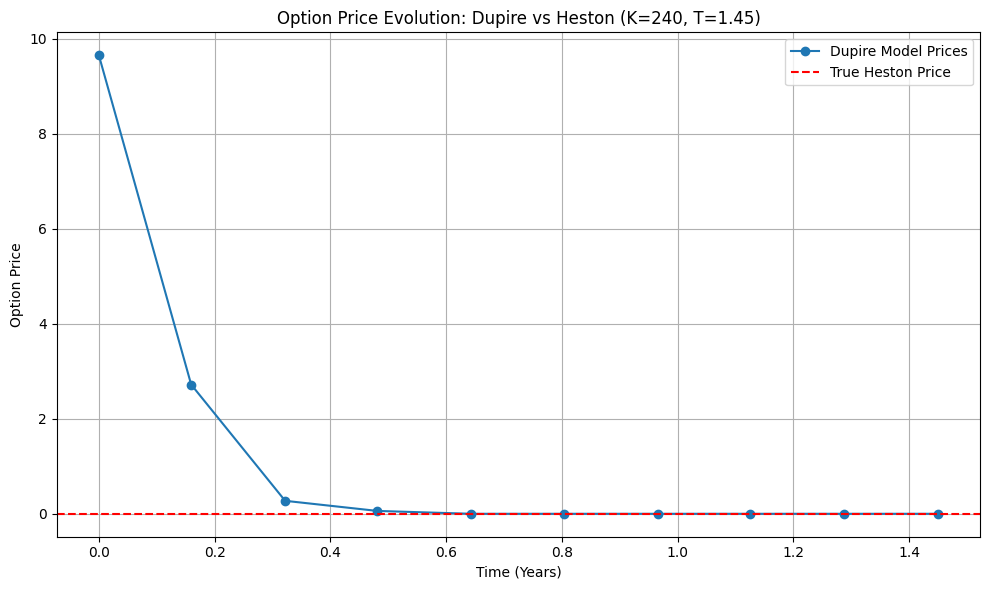

In [56]:

# === Plot ===
plt.figure(figsize=(10, 6))
plt.plot(t_obs, dupire_prices, marker='o', label='Dupire Model Prices')
plt.axhline(true_price, color='r', linestyle='--', label='True Heston Price')
plt.xlabel('Time (Years)')
plt.ylabel('Option Price')
plt.title(f'Option Price Evolution: Dupire vs Heston (K={K_new}, T={T_new})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
